# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

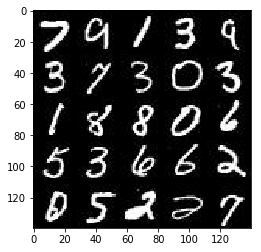

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

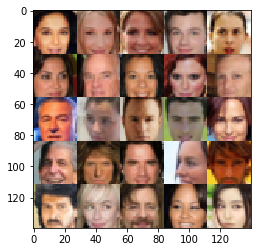

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, [ None, image_width, image_height, image_channels ], name = 'input_images')
    input_z = tf.placeholder(tf.float32, [ None, z_dim ], name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], name = 'learning_rate')
    return input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse) as scope:
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 1, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not is_train) as scope:
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 1, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding = 'same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    (_, image_width, image_height, image_channels) = data_shape
    
    p_input_real, p_input_z, p_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(p_input_real, p_input_z, image_channels, alpha=0.2)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, p_learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = 2.0 * batch_images
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={p_input_real: batch_images, p_input_z: batch_z, p_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={p_input_z: batch_z, p_input_real: batch_images, p_learning_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({p_input_z: batch_z, p_input_real: batch_images})
                    train_loss_g = g_loss.eval({p_input_z: batch_z})

                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, p_input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 2.4830... Generator Loss: 2.1532
Epoch 1/2... Discriminator Loss: 3.1694... Generator Loss: 0.1094
Epoch 1/2... Discriminator Loss: 1.6763... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.9942... Generator Loss: 0.1981
Epoch 1/2... Discriminator Loss: 1.7595... Generator Loss: 1.8323
Epoch 1/2... Discriminator Loss: 1.9459... Generator Loss: 2.0864
Epoch 1/2... Discriminator Loss: 1.9206... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.2782
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.7395


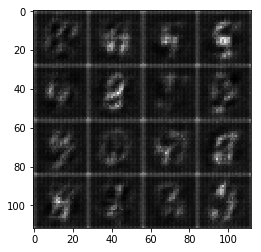

Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 2.0321
Epoch 1/2... Discriminator Loss: 1.1932... Generator Loss: 2.1688
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.5018
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.7689
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 0.9724
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 2.7016


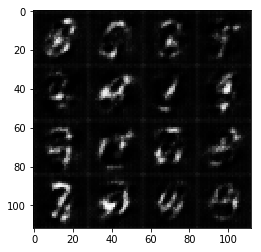

Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 0.6684
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.8183
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 2.0728
Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.1256
Epoch 1/2... Discriminator Loss: 1.5589... Generator Loss: 0.3476


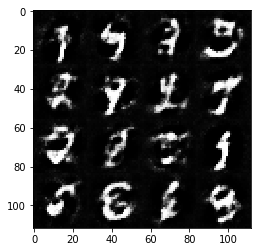

Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 1.5083
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.4748... Generator Loss: 0.3361
Epoch 1/2... Discriminator Loss: 0.9225... Generator Loss: 1.5591
Epoch 1/2... Discriminator Loss: 0.9458... Generator Loss: 0.8962
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 2.3457
Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.4824


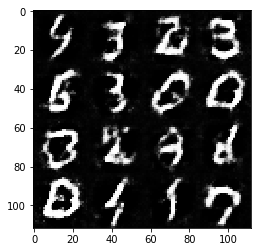

Epoch 1/2... Discriminator Loss: 0.8081... Generator Loss: 1.5282
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.2457
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 1.4010
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.0981


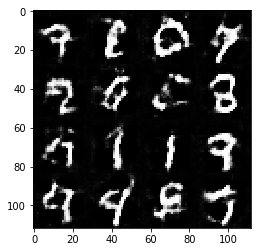

Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.8835
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 2.0956
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.4795
Epoch 1/2... Discriminator Loss: 1.0583... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 2.0313... Generator Loss: 2.9636
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 0.9907


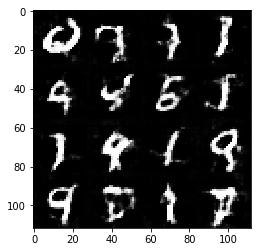

Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.3632
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 0.7249
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 0.7061... Generator Loss: 1.4334
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.4008


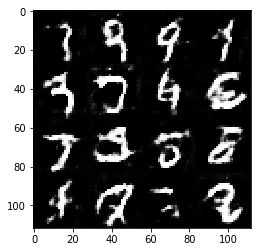

Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.2619
Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 2.2919
Epoch 1/2... Discriminator Loss: 1.8294... Generator Loss: 0.2715
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 0.5906... Generator Loss: 1.2178
Epoch 1/2... Discriminator Loss: 0.6730... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 0.6144... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 0.8462
Epoch 1/2... Discriminator Loss: 0.9360... Generator Loss: 0.6824


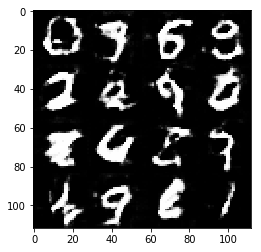

Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 0.6925... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 0.7808... Generator Loss: 1.4655
Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 1.2001


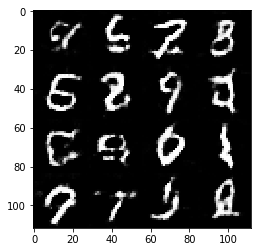

Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 0.6794... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 3.2789... Generator Loss: 0.0936
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.2025
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.7847
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.0923
Epoch 2/2... Discriminator Loss: 0.7907... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.1811


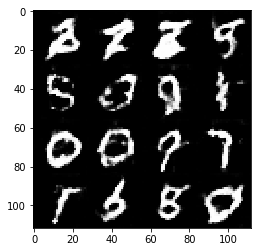

Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.3547
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 0.5780... Generator Loss: 1.3059
Epoch 2/2... Discriminator Loss: 0.4957... Generator Loss: 1.9467
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.1981
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 1.5487
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.5194


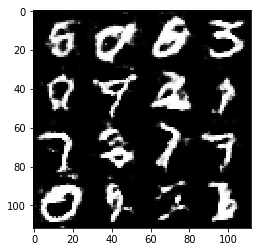

Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.5067
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 0.5088... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.5448
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 2.0127
Epoch 2/2... Discriminator Loss: 0.4831... Generator Loss: 1.3351
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 0.5065... Generator Loss: 1.3388


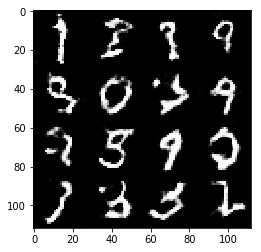

Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.6798
Epoch 2/2... Discriminator Loss: 1.5777... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.3550


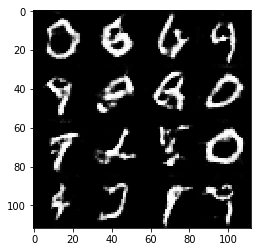

Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.2811
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.5985
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 0.8311
Epoch 2/2... Discriminator Loss: 4.3159... Generator Loss: 7.4623
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.7737
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 0.7340... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 0.6326... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 0.9286... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 1.1443


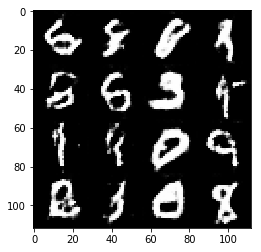

Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.5354
Epoch 2/2... Discriminator Loss: 1.8393... Generator Loss: 0.2349
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 0.7588... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 0.4672... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 0.4857... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.2035
Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 0.7502... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.4451... Generator Loss: 1.6477


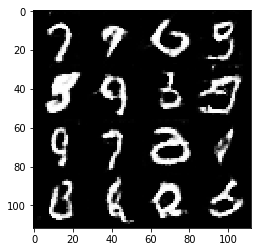

Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.5959
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.4661
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 0.6174
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.1603
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.0256
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 0.4690... Generator Loss: 1.6216
Epoch 2/2... Discriminator Loss: 0.5689... Generator Loss: 1.2928
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 0.7021


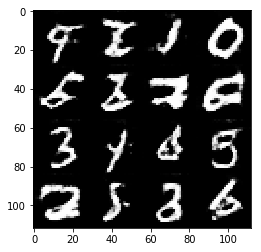

Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 2.3152
Epoch 2/2... Discriminator Loss: 0.5988... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.5577... Generator Loss: 1.2467
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.8673
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 1.4057
Epoch 2/2... Discriminator Loss: 0.5028... Generator Loss: 1.2961


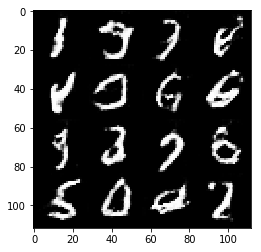

Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 0.6864
Epoch 2/2... Discriminator Loss: 0.5040... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 0.5343... Generator Loss: 1.4773
Epoch 2/2... Discriminator Loss: 0.6805... Generator Loss: 2.7645
Epoch 2/2... Discriminator Loss: 0.7331... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 0.9815
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 2.7132... Generator Loss: 0.1417


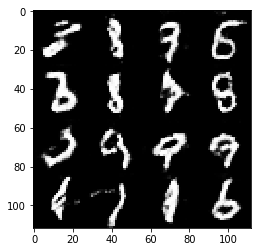

Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.4060
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 0.7750... Generator Loss: 0.9551
Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.5760... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 1.6892
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 0.9418


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1743... Generator Loss: 0.2204
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 2.2532
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 1.3553


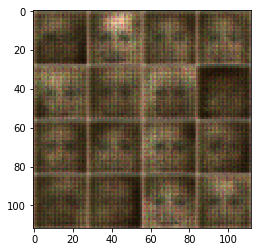

Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.3094
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.4268
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.3951


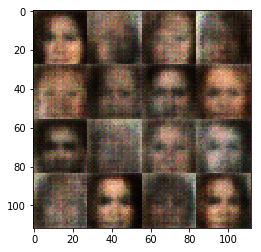

Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 1.5342
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6104


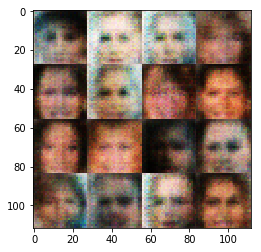

Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.4815


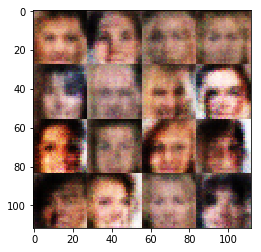

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8496


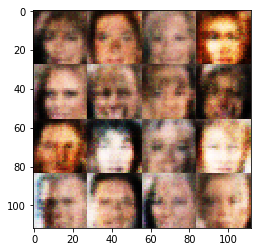

Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.9121


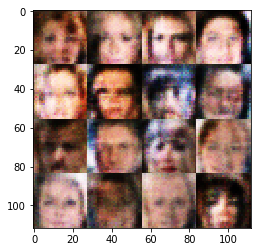

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5626


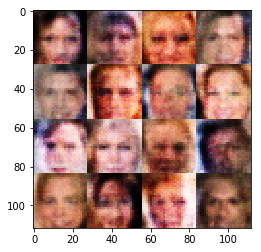

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7022


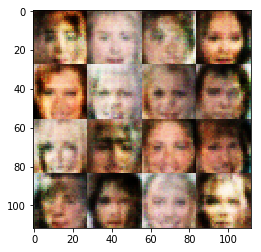

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8961


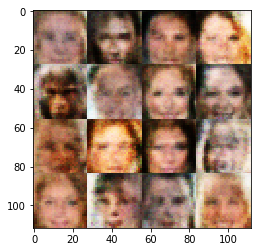

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.4359


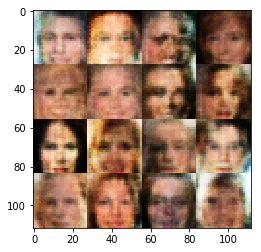

Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5033


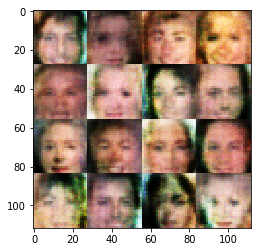

Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5963


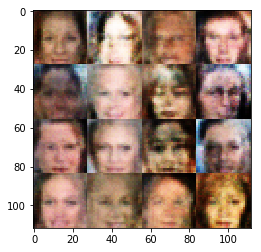

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7465


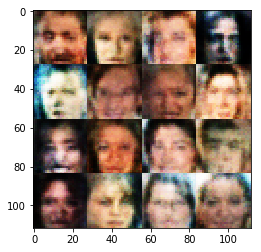

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5511


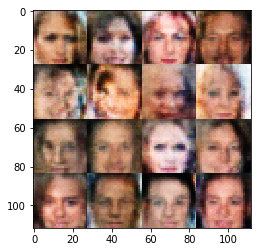

Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7786


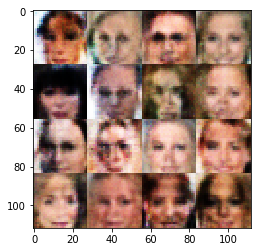

Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5686


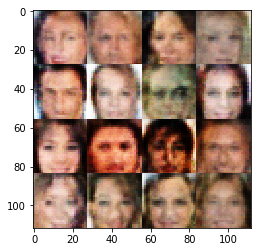

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.3464
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8930


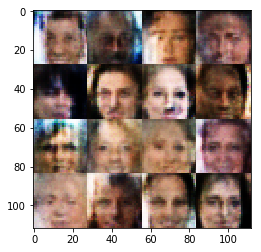

Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 2.3509
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 0.3228
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 1.0126
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 1.0480


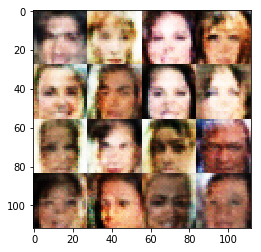

Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 2.1351
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 2.3046
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 2.0285


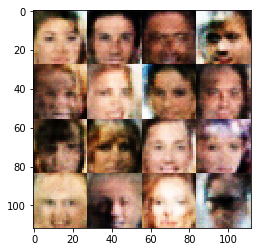

Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 1.9406
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.5247
Epoch 1/1... Discriminator Loss: 1.8717... Generator Loss: 0.2066


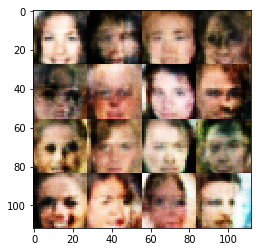

Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 4.4753
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 0.4945... Generator Loss: 1.8842
Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 3.4850
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 2.0505
Epoch 1/1... Discriminator Loss: 0.6276... Generator Loss: 3.4177
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 0.7581


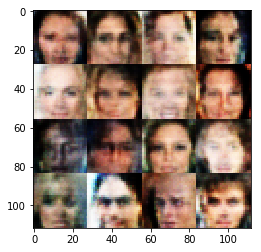

Epoch 1/1... Discriminator Loss: 0.3248... Generator Loss: 2.9566
Epoch 1/1... Discriminator Loss: 0.3113... Generator Loss: 1.9645
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 1.7728
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.8306
Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 1.5903
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 3.7890
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 4.3878
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 2.3608


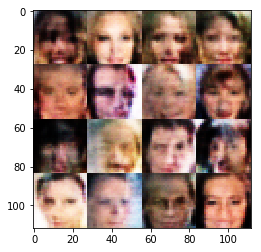

Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 3.0223
Epoch 1/1... Discriminator Loss: 0.2781... Generator Loss: 2.2204
Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 4.0624
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.6812
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 0.2826... Generator Loss: 2.3359
Epoch 1/1... Discriminator Loss: 0.2725... Generator Loss: 5.0662
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 2.2983


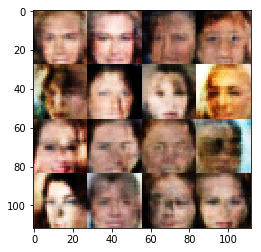

Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.9475
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 4.0253
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 0.4810... Generator Loss: 1.9393
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.3544
Epoch 1/1... Discriminator Loss: 0.6610... Generator Loss: 4.8570
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 2.9963


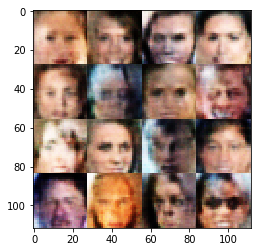

Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 1.5510
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 2.9687
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 5.0661
Epoch 1/1... Discriminator Loss: 0.2423... Generator Loss: 2.3659
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.4615
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 3.2486
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 1.6914
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 5.2633


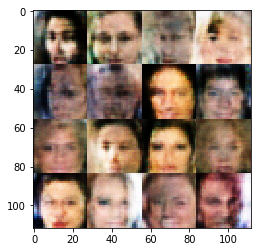

Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 2.3637
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 4.4120
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 2.3501
Epoch 1/1... Discriminator Loss: 0.5650... Generator Loss: 2.0350
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.2641
Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 4.5544
Epoch 1/1... Discriminator Loss: 0.2417... Generator Loss: 2.2065
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.5666


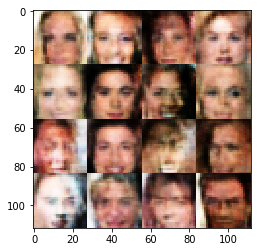

Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 2.2846
Epoch 1/1... Discriminator Loss: 0.2161... Generator Loss: 2.3449
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 0.3026... Generator Loss: 2.3724
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 4.2152
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 0.4890... Generator Loss: 4.7283
Epoch 1/1... Discriminator Loss: 0.3109... Generator Loss: 1.8635
Epoch 1/1... Discriminator Loss: 0.3241... Generator Loss: 4.2698
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 0.8832


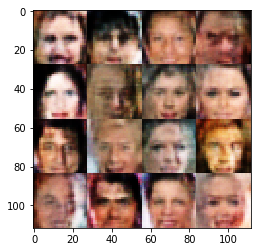

Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 1.6315
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 1.4915
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.9883
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.7695
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 1.6771
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.3190... Generator Loss: 3.0899
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.5258


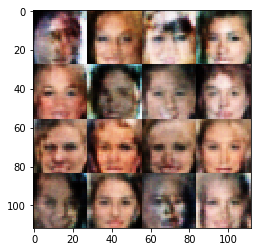

Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 2.0466... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 3.6268
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 2.1101
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 2.3229
Epoch 1/1... Discriminator Loss: 0.2587... Generator Loss: 2.1270
Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.1919... Generator Loss: 2.3505
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 1.3536


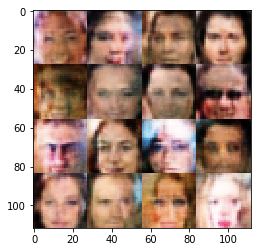

Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 2.0678
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 5.2097
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 3.1326
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 3.1879
Epoch 1/1... Discriminator Loss: 0.2900... Generator Loss: 2.0727
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 2.6793
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.6508
Epoch 1/1... Discriminator Loss: 0.2030... Generator Loss: 2.7858
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 4.0462
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 5.9330


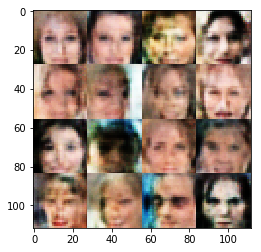

Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 2.8169
Epoch 1/1... Discriminator Loss: 0.2961... Generator Loss: 3.9163
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 0.2373... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 2.5289
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 3.2150
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 3.2964
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 2.7754


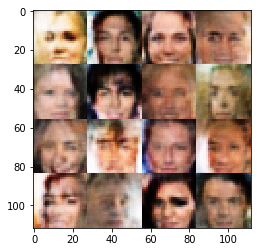

Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.4851... Generator Loss: 4.5886
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 3.0253
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 1.1851


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.